# Final deliverable
This is the notebook that has the final info.

There is some story information, but we did this notebook under the assumption that it's mainly to display graphs, how we got them, logic behind the code, that kind of thing. The actual story in detail will be kept in the main readme.

Table of Contents <br>

0. Import Modules
1. Data reading
2. Descriptive data analysis
3. Ways to enrich, filter, transform the data
4. Plan and Ideas for Methods

# 0. Import modules
Feel free to use the virtual environment (amonavis) included in the GitHub folder.

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Visualization Libraries
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Network Analysis Library
import networkx as nx

# Statistical Libraries
import statistics

# Machine Learning and Data Preprocessing Libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import torch

# Utility and System Libraries
from datetime import datetime
import warnings
from tqdm import TqdmWarning
import time
import ast
from urllib.parse import unquote

# Custom Utility Functions
import data_readers
import plot_functions
import machine_searchers

# Configure Warning Filters
warnings.filterwarnings('ignore', category=TqdmWarning)


# 1. Data Reading and Cleaning
The following code reads the data and saves them in the appropriate variables.
<br><br>
**Wikispeedia**
This will hold our graph where Wikipedia articles are nodes and links/paths between them are edges.

<br><br>
**finished_paths**
The datafile includes the hashedIpAddress, timestamp, durationInSec, path, and rating of games that were completed.
We also add columns with the first article (soruce), last article (target), path length (#articles), and a readable date in Timestamp format.

<br><br>
**unfinished_paths**
This datafile is similar to finished_paths, but with games that weren't completed. It has the hashedIpAddress, timestamp, durationInSec, path, target, and type of failure (either timeout or restart).

<br><br>
**articles**
Dataframe with the name of all articles in the dataset.

<br><br>
**categories**
This shows the higher category classification of each article. For example, Áedán mac Gabráin is part of 'subject.History.British_History.British_History_1500_and_before_including_Roman_Britain'

In [2]:
# The links and edges
wikispeedia = data_readers.read_wikispeedia_graph()

# The finished paths
finished_paths = data_readers.read_finished_paths()
finished_paths_backup = finished_paths.copy()

# The unfinished paths
unfinished_paths = data_readers.read_unfinished_paths()

# DF of all articles
articles = data_readers.read_articles()

# DF of all articles and their categories
categories = data_readers.read_categories()

# We found out later that the data contained in the shortest path matrix given to us seems to be wrong
# Here we also add a quick dictionary that properly shows that this is wrong, and give an example
shortest_path_df = data_readers.read_shortest_path_df()
shortest_path_dict = dict(nx.all_pairs_shortest_path(wikispeedia))

# Searching for the string of a given article. It has to be formatted like the article name
# Which shouldn't be a problem, as we'll probably usually retrieve them internally
obi_wan_text = data_readers.plaintext_article_finder('Obi-Wan_Kenobi')

These are less nodes than the reported number, it should be 4,604 nodes.

The 119,882 edges is correct though.

The difference is probably due to some nodes not being connected to the rest of the graph, as here we read in only the articles that are connected. The few nodes that we are losing do not matter for what we need.

### Modify given datasets.

In [3]:
finished_paths = finished_paths[['first_article', 'last_article', 'path_length', 'path']]
finished_paths = finished_paths.rename(columns={'first_article':'source', 'last_article':'target', 'path_length':'length','path':'visited'})

unfinished_paths['source'] = unfinished_paths['path'].str.split(';').apply(lambda x: x[0])
unfinished_paths = unfinished_paths[['source', 'target', 'path', 'type']]

In [4]:
def add_category_of_target_article(df_to_add_category_to) -> pd.DataFrame:
    categories[categories['article'].duplicated()]
    categories['article'] = categories['article'].drop_duplicates()
    sub_categories = categories['categories'].str[8:].str.split('.')
    category_depth_1 = sub_categories.apply(lambda x: x[0])
    categories['category'] = category_depth_1

    new_df = pd.merge(df_to_add_category_to, categories, left_on = 'target', right_on= 'article', how = 'left')
    new_df = new_df.drop(columns = ['article', 'categories'])
    return new_df

finished_paths = add_category_of_target_article(finished_paths)
unfinished_paths = add_category_of_target_article(unfinished_paths)

# landmark_df = add_category_of_target_article(landmark_df)
# semantic_rank_df = add_category_of_target_article(semantic_rank_df)
# carlos_df = add_category_of_target_article(carlos_df)

# 2. Study of the Game: Descriptive Data Analysis
Here, we show that we understand what’s in the data (formats, distributions, missing values, correlations, etc.).


### 2.1. How many: articles, links, finished games, unfinished games?


In [5]:
print("There are", len(wikispeedia.nodes), "articles in the dataset.")
print("There are", len(wikispeedia.edges), "links/paths.")
print("There are", finished_paths.shape[0], "finished games.")
print("There are", unfinished_paths.shape[0], "unfinished games.")

There are 4592 articles in the dataset.
There are 119882 links/paths.
There are 51318 finished games.
There are 24875 unfinished games.


These are less nodes than the reported number, it should be 4,604 nodes.

The 119,882 edges is correct though.

The difference is probably due to some nodes not being connected to the rest of the graph, as here we read in only the articles that are connected. The few nodes that we are losing do not matter for what we need.

In [6]:
unique_paths = finished_paths['visited'].unique()
print('There are', len(unique_paths), 'unique finshed paths in the dataset')

There are 47856 unique finshed paths in the dataset


### 2.2. Degree of a Node
We first want to get an idea of the node degree distribution

The degree of a node is the number of edges/links it has. We plot a complementary cumulative distribution function (CCDF) of degree for each article/node, using a log log scale.

In [136]:
# Recreating the CCDF plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=degree_values,
    y=ccdf,
    mode='markers+lines',
    marker=dict(color='blue')
))

fig.update_layout(
    title='CCDF of Node Degrees',
    xaxis=dict(
        type='log',
        title='Degree'
    ),
    yaxis=dict(
        type='log',
        title='Complementary Cumulative Distribution Function (CCDF)'
    ),
    autosize=False,
    width=700,  # width in pixels (5 inches, assuming 100 pixels per inch)
    height=500  # height in pixels
)

# Show the plot
fig.show()
fig.write_html('ccdf_plot.html')

What are the "hubs"? Which nodes have more than 500 links?

In [8]:
art_more1000 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 1000]
art_500_1000 = [node for node in wikispeedia.nodes if (wikispeedia.degree(node) >= 500)&(wikispeedia.degree(node) < 1000)]
art_300_500 = [node for node in wikispeedia.nodes if (wikispeedia.degree(node) >= 300)&(wikispeedia.degree(node) < 500)]

print("Nodes with > 1000 edges: ", len(art_more1000), "nodes ||||", art_more1000)
print('')
print("Nodes with 500-1000 edges: ", len(art_500_1000), "nodes ||||", art_500_1000)
print('')
print("Nodes with 300-500 edges:  ", len(art_300_500), "nodes ||||", art_300_500)

Nodes with > 1000 edges:  4 nodes |||| ['United_Kingdom', 'France', 'United_States', 'Europe']

Nodes with 500-1000 edges:  16 nodes |||| ['Russia', 'World_War_II', 'Germany', 'Italy', 'Canada', 'English_language', 'England', 'Spain', 'India', 'China', 'Australia', 'Japan', 'London', 'Africa', 'Animal', 'Scientific_classification']

Nodes with 300-500 edges:   47 nodes |||| ['Ireland', 'Scotland', '20th_century', 'Currency', 'European_Union', 'List_of_countries_by_system_of_government', 'Sweden', 'Time_zone', 'Netherlands', 'Paris', 'Atlantic_Ocean', 'Greece', 'Portugal', 'Soviet_Union', 'United_Nations', 'Mexico', 'Poland', '19th_century', 'North_America', 'Iran', 'Asia', 'Islam', 'Christianity', 'Jew', 'Earth', 'Water', 'Brazil', 'Egypt', 'Roman_Catholic_Church', 'New_York_City', 'New_Zealand', 'South_Africa', 'South_America', 'Israel', 'People%27s_Republic_of_China', 'Human', 'World_War_I', 'Argentina', 'Lebanon', 'Turkey', 'German_language', 'Latin', 'French_language', 'List_of_cou

Observe that biggest hubs are mainly countries. The 'United Kingdom', 'France', 'United States', and 'Europe' have over 1000 links. Since there are 4592 nodes, these nodes have link to almost 1/4 of the dataset!

Another way of measuring hubs is this concept called betweenness centrality. The idea is that if we imagine paths as a message flowing, the nodes that form bottlenecks of the graph have the highest value for this. We will only print 40 of them to keep visuals manageable

In [9]:
# This takes approximately 1 min 40s to run
betweenness_centrality = nx.betweenness_centrality(wikispeedia)
bc_series = pd.Series(betweenness_centrality)
bc_series.sort_values(inplace=True, ascending=False)
bc_series[:40]

United_States       0.094090
United_Kingdom      0.042384
England             0.032403
Europe              0.026992
Africa              0.024204
Germany             0.019409
World_War_II        0.015500
19th_century        0.014824
London              0.014675
English_language    0.014041
Earth               0.013850
Japan               0.012973
Australia           0.012527
France              0.012002
India               0.011256
China               0.010256
Russia              0.009509
Canada              0.009267
Asia                0.008728
Human               0.008689
Water               0.008643
Atlantic_Ocean      0.008487
Bird                0.008446
Scotland            0.008172
20th_century        0.008161
Dinosaur            0.008051
Paris               0.007774
Argentina           0.007605
New_Zealand         0.007245
Italy               0.007087
World_War_I         0.006770
South_Africa        0.006554
Netherlands         0.006301
Computer            0.006296
Volcano       

How many nodes have more than 20 links? How many have only 1 link?

In [10]:
# Get the percentages
total_nodes = len(wikispeedia.nodes)
print('Total number of nodes:', total_nodes, '\n')

# Count the number of nodes with degree 1
nodes_degree_1 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) == 1]
print('Nodes with degree 1: ',len(nodes_degree_1), "nodes ||||", nodes_degree_1)
# print percentage over total
print('Percentage of nodes with degree 1: ', len(nodes_degree_1) / total_nodes, '\n')

percentage_degree_1 = (len(nodes_degree_1) / total_nodes)
#print('% of nodes that have only 1 edge/link:', percentage_degree_1)

# Count number of nodes with degree <= 20
nodes_degree_20 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) <= 20]
print('Nodes with degree <=20: ',len(nodes_degree_20))
print('Percentage of nodes with degree <=20: ', len(nodes_degree_20) / total_nodes)

Total number of nodes: 4592 

Nodes with degree 1:  13 nodes |||| ['All_your_base_are_belong_to_us', 'Local_community', 'Dewey_Square', 'Emma_Roberts', 'Human_abdomen', 'Pere_Marquette_1225', 'Pro_Milone', 'Sunol_Water_Temple', 'T._D._Judah', 'Terik', 'Duchenne_muscular_dystrophy', 'Klinefelter%27s_syndrome', 'White_Mountain_art']
Percentage of nodes with degree 1:  0.0028310104529616726 

Nodes with degree <=20:  1581
Percentage of nodes with degree <=20:  0.344294425087108


### 2.3. PageRank

We also want to find information about the PageRank of the nodes. This is because PageRank provides more detailed information than just the edge count, by allowing us to understand how well connected a node truly is to the rest.

PageRank computes a ranking of the nodes in the graph based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.


In [11]:
# PageRank Dictionary: {key: value} -> {'article_title': pagerank}
dic = nx.pagerank(wikispeedia)

# Assign pagerank as a node attribute of Wikispeedia graph
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['pagerank'] = dic[node]
#print(wikispeedia.nodes(data=True))
    
average = sum(dic.values()) / len(dic)
print('Average PageRank:', average)

# Above Average
above_average = {key: value for key, value in dic.items() if value >= average}
num_elements_above_avg = len(above_average)
print("Number of elements above average: ", num_elements_above_avg)

# Median PageRank
values = list(dic.values())
median = statistics.median(values)
print('Median PageRank: ', median)

# order dictionary to visualize articles following plot
above_median = {key: value for key, value in dic.items() if value >= median}
above_median_ordered = {k: v for k, v in sorted(above_median.items(), key=lambda item: item[1], reverse=True)}

num_elements_above_median = len(above_median)
print('Number of elements above average median: ', num_elements_above_median)

Average PageRank: 0.00021777003484320113
Number of elements above average:  1134
Median PageRank:  8.689532387656443e-05
Number of elements above average median:  2296


PageRank in descending order of the articles above the median (50% data)

Text(0.5, 1.0, 'PageRank Classification of 40 Wikispeedia Articles with Highest PageRank')

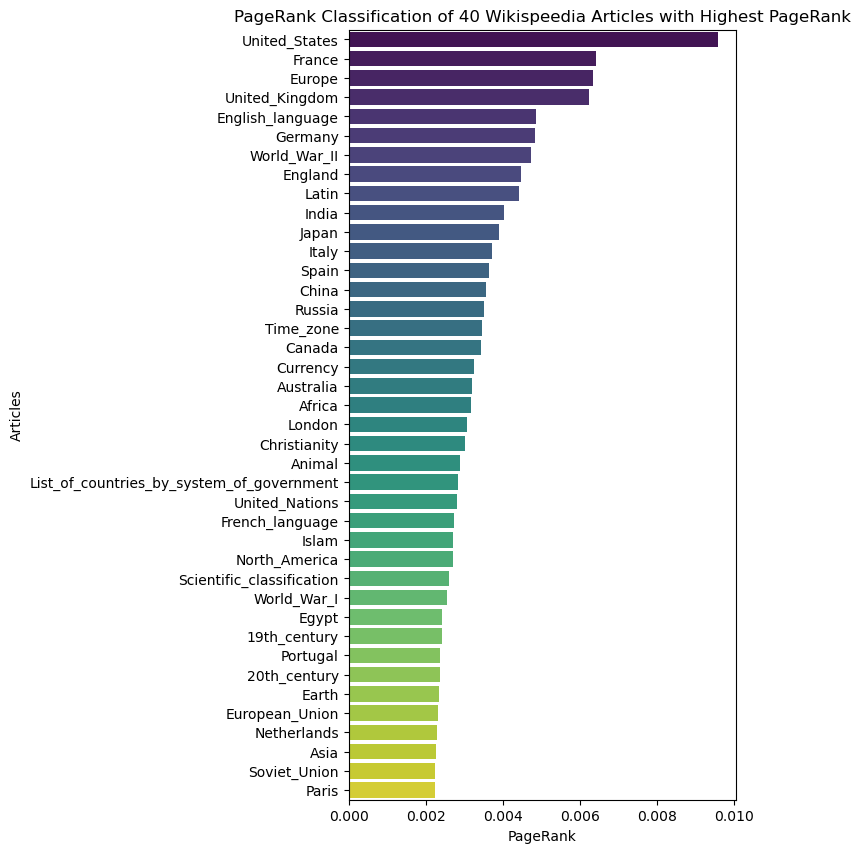

In [12]:
# Top N PageRank
n = 40
names = list(above_median_ordered.keys())[:40]
values = list(above_median_ordered.values())[:40]

plt.figure(figsize=(5, 10))
sns.barplot(x=values, y=names, palette='viridis')
plt.xlabel('PageRank')
plt.ylabel('Articles')
plt.title('PageRank Classification of 40 Wikispeedia Articles with Highest PageRank')
# plt.show()

For the Page, we will use Plotly functions instead

In [126]:
n = 40
names_top_n = names[:n]
values_top_n = values[:n]

fig = go.Figure(go.Bar(
    x=values_top_n,
    y=names_top_n,
    orientation='h',
    marker=dict(color=values, colorscale='Viridis') 
))

fig.update_layout(
    title='PageRank of Top 40 Wikispeedia Articles',
    xaxis_title='PageRank',
    yaxis_title='Articles',
    height=800, 
    margin=dict(l=150),  
)
fig.show()

fig.write_html("Plotly_PageRank40.html")

### 2.4. Average Distance between Articles
On average, how many links/edges does it take to connect any random two articles?

In [14]:
# Our graph is not strongly connected, meaning it's not possible to reach every node from every other node
# So we can't use the built in function nx.average_shortest_path_length

# This takes a long time to run (30 sec)
shortest_paths = list(nx.all_pairs_shortest_path_length(wikispeedia))
reachable_pairs = [(source, target, length) for source, paths in shortest_paths for target, length in paths.items() if length != float('inf')]
total_distances = sum(length for _, _, length in reachable_pairs)
average_distance = total_distances / len(reachable_pairs) if reachable_pairs else 0
print(f"Average distance between reachable nodes: {average_distance:.2f}")

Average distance between reachable nodes: 3.20


### 2.5. Issue with the shortest path
The shortest paths that were calculated are wrong. This is just a simple example to show that at least one of the points is wrong. We assume this is common enough elsewhere, as the effort needed to properly prove this is too large.

We double-checked the method for reading in the data, and there are no big changes to be done there. We also double-checked that the graph is a directed graph, which matters for this search. Additionally, we manually checked the edges, so we know that the following example is correct.

In [15]:
# We have to put the strings into tuples to make this work. It's ugly, but this works
print("Shortest path from Actor to Japan in the given matrix is:", shortest_path_df[('Actor',)][('Japan',)])

print("Shortest path from Actor to Japan according to networkX is:", len(shortest_path_dict['Actor']['Japan'])-1)

print("The actual path is:", shortest_path_dict['Actor']['Japan'])

Shortest path from Actor to Japan in the given matrix is: 3
Shortest path from Actor to Japan according to networkX is: 1
The actual path is: ['Actor', 'Japan']


In [16]:
# No need to print the entire text, just show that reading it in works
obi_wan_text[:100]

'   #copyright\n\nObi-Wan Kenobi\n\n2007 Schools Wikipedia Selection. Related subjects: Films\n\n   Star Wa'

# 3. Study of Man

### 3.1. Games per Time
Histogram of the number of games at each point in time.


In [17]:
# Convert timestamps to datetime objects
timestamps = finished_paths_backup['timestamp']
date_times = [datetime.utcfromtimestamp(ts) for ts in timestamps]

df = pd.DataFrame({'Timestamps': date_times})

fig = go.Figure(data=[go.Histogram(x=df['Timestamps'], nbinsx=20, marker_color='skyblue')])

fig.update_layout(
    title='Distribution of Timestamps',
    xaxis_title='Time',
    yaxis_title='Frequency',
    xaxis=dict(tickangle=45), 
    width=700,  
    height=500
)

fig.show()


A lot of games were played in Q3 2009! 

In [18]:
q3_2009_times = [dt for dt in date_times if dt.year == 2009 and dt.month in [7, 8, 9]]
percent_q3_2009_times = len(q3_2009_times) / len(date_times)
print(f"Percent of finished games completed in Q3 2009: {percent_q3_2009_times:.2f}")


Percent of finished games completed in Q3 2009: 0.24


### 3.2. Which categories of games are more likely to be finished or unfinished? 

In [19]:
def process_row(row):
    node = row['target']
    
    if not categories[categories['article'] == node].empty:
        category_string = categories[categories['article'] == node]['categories'].values[0]
        return category_string.split('.')[1]
    else:
        return 'Unknown'

# Use the apply function to process each row
finished_paths['category'] = finished_paths.apply(lambda row: process_row(row), axis=1)

In [20]:
print('There are', categories['article'].duplicated().sum(), 'articles with more than 1 category.')

print('Should we drop the duplicate categories, or doublecount them?')
print('This corresponds to', categories['article'].duplicated().sum() / len(wikispeedia.nodes), 'of the articles.')

# Let's drop them for now.
categories['article'] = categories['article'].drop_duplicates()
print('The new shape is: ',categories.shape)

# Why are there more articles here than nodes (# articles)?

There are 605 articles with more than 1 category.
Should we drop the duplicate categories, or doublecount them?
This corresponds to 0.13175087108013936 of the articles.
The new shape is:  (5204, 3)


In [21]:
category_counts_finished = finished_paths['category'].value_counts()
category_counts_unfinished = unfinished_paths['category'].value_counts()

plot_functions.barplot_solo(category_counts_finished, file_name= 'category_counts_finished', title = "Frequency of Categories of Target Articles in Finished Paths", color = 'red')
plot_functions.barplot_solo(category_counts_unfinished, file_name= 'category_counts_unfinished', title = " Frequency of Categories of Target Articles in Unfinished Paths", color = 'blue')

Notice that targets in the science category make up the largest proportion of unfinished games. Is this because most of the articles are from the science category, or if because players really like clicking science articles? Let's normalize by dividing by the number of articles in each category. 

In [22]:
def normalize_category_frequency_by_num_articles_they_have(paths_df, category_df = categories) -> pd.DataFrame:
    # Returns frequency of categories of target articles in finished/unfinished paths
    category_counts = paths_df['category'].value_counts()
    num_articles_per_category = categories.groupby('category')['article'].count()
    normalized_category_counts = category_counts / num_articles_per_category
    normalized_category_counts = normalized_category_counts.sort_values(ascending=False)
    return normalized_category_counts

normalized_category_counts_finished = normalize_category_frequency_by_num_articles_they_have(finished_paths)
normalized_category_counts_unfinished = normalize_category_frequency_by_num_articles_they_have(unfinished_paths)

plot_functions.barplot_solo(normalized_category_counts_finished, file_name= 'normalized_category_counts_finished', title = "Normalized Frequency of Categories of Target Articles in Finished Paths", color = 'red')
plot_functions.barplot_solo(normalized_category_counts_unfinished, file_name= 'normalized_category_counts_unfinished', title = "Normalized Frequency of Categories of Target Articles in Unfinished Paths", color = 'blue')


### 3.3 Distribution of Finished Path Lengths taken by Humans

In [127]:
fig = px.histogram(finished_paths, x='length', title='Distribution of Finished Path Lengths taken by Humans', range_x=[0, finished_paths['length'].max()])
fig.show()
fig.write_html("Figures/Plotly_distr_finished_path_length_humans.html")

This graph seems wrong, as the X axis is incredibly skewed. We checked in detail why this was happening, and found that there are people that are really stubborn while playing the game. In particular, one poor fellow visited 435 different pages trying to find a link between “United States” and “English Language”. Which is slightly unrelated, but is rather hilarious as a find. At the very least, the guy is stubborn and manages to find a link eventually.
We redid the plot only taking in the players that took less than 25. This arbitrary value was chosen just for visualization purpose.


In [128]:
trimmed_finished = finished_paths[finished_paths['length'] <= 25]
fig = px.histogram(trimmed_finished, x='length', title = 'Histogram of Path Lengths under 25 on Human data')
fig.show()
fig.write_html("Figures/Plotly_distr_finished_path_length_25_humans.html")

### 3.4. Study of Unique Paths
Here we study the unique source and target pairs. We will use the dataframes to compare the performance between humans and machines, as well as to know what paths to make machines complete.

**article_combinations**

This dataframe contains information on all the combination of source and target articles in the finished games (paths). It includes how many times it has been played, and the mean and std of the path length, duration of the game, and rating.

**unique_targets** and **unique_sources**

These dataframes include all the sources and targets that appears in the finished games

<br><br>
Note that we don't change to ASCII the name of the articles yet. We will do it at a later step if we need to.
<br><br>

In [25]:
finished_paths

source                  target  \
0                                    14th_century     African_slave_trade   
1                                    14th_century     African_slave_trade   
2                                    14th_century     African_slave_trade   
3                                    14th_century                  Greece   
4                                    14th_century         John_F._Kennedy   
...                                           ...                     ...   
51313                                       Yagan            Civilization   
51314                                       Yagan                 Fiction   
51315                                       Yagan  U.S._Open_%28tennis%29   
51316  Yarralumla%2C_Australian_Capital_Territory         Abraham_Lincoln   
51317                                 Ziad_Jarrah                     Jew   

       length                                            visited  \
0           9  14th_century;15th_century;16th_century;Pacific...   
1           5  14th_century;Europe;Africa;Atlantic_slave_trad...   
2           8  14th_century;Niger;Nigeria;British_Empire;Slav...   
3           4     14th_century;Renaissance;Ancient_Greece;Greece   
4           7  14th_century;Italy;Roman_Catholic_Church;HIV;R...   
...       ...                                                ...   
51313       3                   Yagan;Ancient_Egypt;Civilization   
51314       9  Yagan;Folklore;Brothers_Grimm;<;19th_century;C...   
51315       7  Yagan;Australia;England;France;United_States;T...   
51316       4  Yarralumla%2C_Australian_Capital_Territory;Aus...   
51317       3                            Ziad_Jarrah;Germany;Jew   

                      category  
0                      History  
1                      History  
2                      History  
3                    Countries  
4                       People  
...                        ...  
51313              Citizenship  
51314  Language_and_literature  
51315            Everyday_life  
51316                   People  
51317                Geography  

[51318 rows x 5 columns]

In [26]:
# How many each pair of articles has been visited
article_combinations_count = finished_paths.groupby(['source', 'target']).size().reset_index(name='count')

# The mean and std of the path length for each pair of articles
article_combinations_stats = finished_paths.groupby(['source', 'target'])['length'].agg(['mean', 'std']).reset_index()
article_combinations_stats['std'] = article_combinations_stats['std'].fillna(0)
article_combinations_stats.rename(columns={'mean': 'mean_length', 'std': 'std_length'}, inplace=True)

"""
We don't use the rating or time.
# The mean and std of the rating for each pair of articles. 
    # Note that mean and std may be nan if there are nan ratings. We purposely leave them as nan, as we don't want to fill them with 0s or 1s.
    # Depending on the application, we could change this in the future if neeeded.
rating_combinations_stats_rating = finished_paths.groupby(['source', 'target'])['rating'].agg(['mean', 'std']).reset_index()
rating_combinations_stats_rating['std'] = rating_combinations_stats_rating['std'].fillna(0)
mask = rating_combinations_stats_rating['mean'].notnull()
rating_combinations_stats_rating.loc[mask, 'std'] = rating_combinations_stats_rating.loc[mask, 'std'].fillna(0)
rating_combinations_stats_rating.rename(columns={'mean': 'mean_rating', 'std': 'std_rating'}, inplace=True)

# The mean and std of the time for each pair of articles.
rating_combinations_stats_time = finished_paths.groupby(['first_article', 'last_article'])['durationInSec'].agg(['mean', 'std']).reset_index()
rating_combinations_stats_time['std'] = rating_combinations_stats_time['std'].fillna(0)
rating_combinations_stats_time.rename(columns={'mean': 'mean_durationInSec', 'std': 'std_durationInSec'}, inplace=True)
"""

# Merging all the dataframes
article_combinations = pd.merge(article_combinations_count, article_combinations_stats, on=['source', 'target'])
# article_combinations = pd.merge(article_combinations, rating_combinations_stats_rating, on=['source', 'target'])
# article_combinations = pd.merge(article_combinations, rating_combinations_stats_time, on=['source', 'target'])
article_combinations = add_category_of_target_article(article_combinations)

# The number of unique sources and targets
unique_sources = finished_paths['source'].value_counts().reset_index()
unique_targets = finished_paths['target'].value_counts().reset_index()

In [27]:
article_combinations.sample(5), unique_targets.sample(5), unique_sources.sample(5)

(                     source                    target  count  mean_length  \
 22800            Scooby-Doo                     Cello      1     8.000000   
 22989         Semiconductor                    Animal      2     4.500000   
 9061      Ernest_Rutherford  Northern_Mariana_Islands      1     7.000000   
 2422   Atlantic_slave_trade                 Pterosaur      3     8.333333   
 5213              Cape_Lion               Bette_Davis      1     6.000000   
 
        std_length   category  
 22800    0.000000      Music  
 22989    0.707107    Science  
 9061     0.000000  Geography  
 2422     3.055050    Science  
 5213     0.000000     People  ,
                target  count
 1128  The_Magic_Flute     14
 1244    Birth_control     13
 2031          Niobium      8
 3166         Concorde      4
 1404         Recorder     11,
                      source  count
 3336              Welsh_law      5
 2001              Mythology     10
 629               Anarchism     17
 1909  Unive

Now we can turn the analysis from 3.2 into a box plot.

In [129]:
fig = go.Figure()

fig.add_trace(go.Box(
    x=article_combinations['category'],
    y=article_combinations['mean_length'],
    marker_color='blue',
    boxmean=True
))

fig.update_layout(
    title='Average Path Length by Category of Target Node (from Finished Human Paths)',
    xaxis=dict(title='Categories'),
    yaxis=dict(title='Average Path Length'),
    showlegend=False,
    hovermode='closest'
)

fig.show()

fig.write_html('avg_path_length_category.html')

### 3.5. Study of hubs, and Appearance ths vs Degree
In the original paper, the authors make a point that hubs are used too commonly by users, and that this might not often be the case for the shortest path.

We want to double check if that holds or not, by checking the number of times a node is used in the paths given in the dataset, versus the number of times they appear in the actual shortest paths.

The only important caveat for this is that the networkX only returns one of the shortest paths, and there might be multiple. It is possible that the different alternate paths give a different result, but for now this is good enough.

In [131]:
# This is just splitting all the values in paths, and doing a value count for each one of those!
paths_per_step = finished_paths['visited'].apply(lambda x: x.split(';')[1:-1])
node_appearance_counts = paths_per_step.explode().value_counts()
node_appearance_counts = node_appearance_counts.rename_axis('Node_Name').reset_index()

# For this, we add the information of the degree of each node, because it's interesting!
degree_dict = dict(wikispeedia.degree())
node_appearance_counts['Degree'] = node_appearance_counts['Node_Name'].map(degree_dict)

#
node_appearance_counts.columns = ['Node_Name', 'count', 'Degree']

# Backspace is included as an element, we drop it
node_appearance_counts = node_appearance_counts[node_appearance_counts.loc[:, 'Node_Name'] != '<']

merged_df = pd.merge(node_appearance_counts, finished_paths[['target', 'category']], left_on='Node_Name', right_on='target', how='left').drop_duplicates()
merged_df.drop(columns=['target'], inplace=True)

# node_appearance_counts.plot.scatter('count', 'Degree')
# plt.title('Appearances in paths versus degree')

fig = px.scatter(merged_df, x='count', y='Degree', color='category', hover_data='Node_Name', opacity=0.5, title='Appearances in paths versus degree')

fig.update_layout(
    title='Appearances in paths versus degree',
    xaxis=dict(title='Count'),
    yaxis=dict(title='Degree')
)

fig.show()
fig.write_html("Figures/Plotly_appearances_in_paths_versus_degree.html")

In [30]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='count ~ Degree', data=node_appearance_counts)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     5090.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:01:35   Log-Likelihood:                -22069.
No. Observations:                3405   AIC:                         4.414e+04
Df Residuals:                    3403   BIC:                         4.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.6768      3.364    -22.794      0.0

Text(0.5, 1.0, 'Appearances in human paths versus degree')

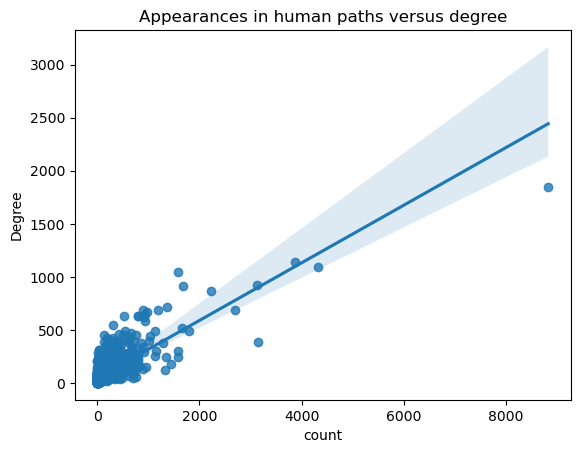

In [31]:
sns.regplot(x='count', y='Degree', data=node_appearance_counts)
plt.title('Appearances in human paths versus degree')

Based on the regression analysis, there is a correlation between how often a node is used in the paths and the degree. So this idea of players using a hub is definitely common for the human dataset.

We can also see that there is a high R squared, considering there is only one variable. So the degree does help explain how often it will appear in the paths.

Now, does this actually hold for the shortest paths?

In [32]:
shortest_path_dict = dict(nx.all_pairs_shortest_path(wikispeedia))

# So, we also remove the first and last element in here
shortest_path_df = pd.DataFrame(shortest_path_dict)
shortest_path_df = pd.melt(shortest_path_df)
# This column is not useful
shortest_path_df = shortest_path_df.drop(['variable'], axis=1)
shortest_path_df = shortest_path_df['value'].dropna()
# This is to remove source and target, to keep the comparison similar
shortest_path_df = shortest_path_df.apply(lambda x: x[1:-1])
# This is to only keep lists that actually have at least one element
shortest_path_df = shortest_path_df[shortest_path_df.map(lambda x: len(x)>0)]

shortest_app_counts = shortest_path_df.explode().value_counts()
shortest_app_counts = shortest_app_counts.rename_axis('Node_Name').reset_index()
shortest_app_counts['Degree'] = shortest_app_counts['Node_Name'].map(degree_dict)

# shortest_app_counts.plot.scatter('value', 'Degree')
# plt.title('Appearances in paths versus degree shortest paths')

Text(0.5, 1.0, 'Appearances in shortest paths versus degree')

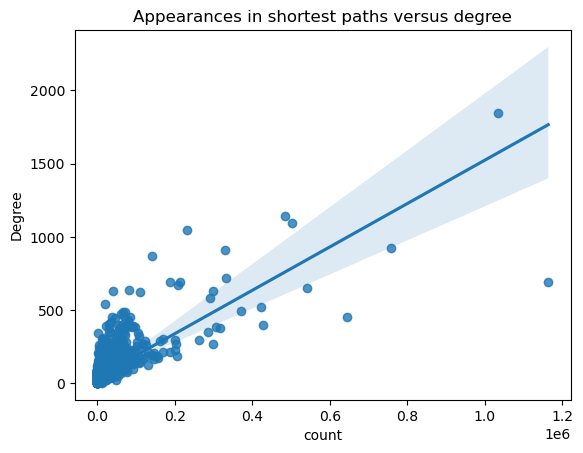

In [33]:
sns.regplot(x='count', y='Degree', data=shortest_app_counts)
plt.title('Appearances in shortest paths versus degree')

In [34]:
mod = smf.ols(formula='count ~ Degree', data=shortest_app_counts)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     4771.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:03:20   Log-Likelihood:                -46255.
No. Observations:                3970   AIC:                         9.251e+04
Df Residuals:                    3968   BIC:                         9.253e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.118e+04    539.844    -20.715      0.0

While the R squared is lower, it is still quite high in this case. Most importantly, it also shows that there is a correlation between the degree and the number of times it appears in a shortest path!

So this implies that hubs are actually very helpful for finding out the path between two nodes, and are commonly used.

This is something that can be used in our AI, and maybe further in other analysis.

2.9.i)

Same thing but with page rank

In [35]:
page_rank = dict(nx.pagerank(wikispeedia))

node_appearance_counts['PageRank'] = node_appearance_counts['Node_Name'].map(page_rank)
shortest_app_counts['PageRank'] = shortest_app_counts['Node_Name'].map(page_rank)

node_appearance_counts.head()

Node_Name  count  Degree  PageRank
1   United_States   8824  1845.0  0.009566
2          Europe   4319  1092.0  0.006340
3  United_Kingdom   3860  1140.0  0.006235
4           Earth   3153   387.0  0.002348
5         England   3123   923.0  0.004474

Text(0.5, 1.0, 'Appearances in human paths versus PageRank')

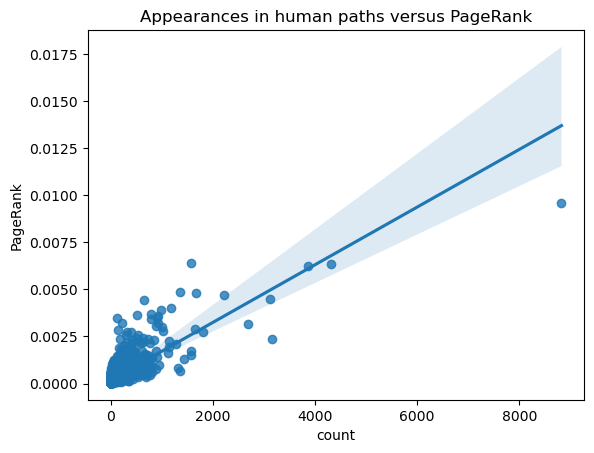

In [36]:
sns.regplot(x='count', y='PageRank', data=node_appearance_counts)
plt.title('Appearances in human paths versus PageRank')

In [37]:
mod = smf.ols(formula='count ~ PageRank', data=node_appearance_counts)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     5472.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:03:20   Log-Likelihood:                -21995.
No. Observations:                3405   AIC:                         4.399e+04
Df Residuals:                    3403   BIC:                         4.401e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -46.5208      3.053    -15.239      0.0

Text(0.5, 1.0, 'Appearances in shortest paths versus PageRank')

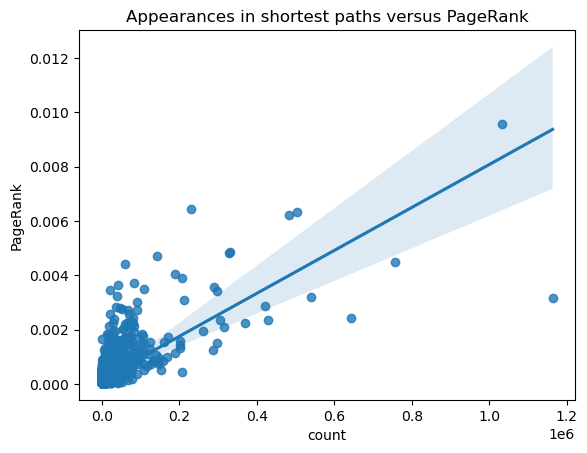

In [38]:
sns.regplot(x='count', y='PageRank', data=shortest_app_counts)
plt.title('Appearances in shortest paths versus PageRank')

In [39]:
mod = smf.ols(formula='count ~ PageRank', data=shortest_app_counts)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     4077.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:03:21   Log-Likelihood:                -46420.
No. Observations:                3970   AIC:                         9.284e+04
Df Residuals:                    3968   BIC:                         9.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5447.4788    521.814    -10.440      0.0

### 3.10. DataFrame and spreadsheet creation 

For future analysis, we may need to filter articles according to some metrics that we may have now or may create in the future. In order to speed up data handling and analysis, we will create the df and store it in a spreadsheet.

In [40]:
data = {}
# establish article name as index
articles_index = list(wikispeedia.nodes())
df = pd.DataFrame(data, index=articles_index)
# add main column
df['articles'] = articles_index
df['Degree'] = degrees.values()
df['PageRank'] = dic.values()
pd.set_option('display.precision', 15) # add precision to the df
df

articles  Degree  \
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in      11   
Bede                                                          Bede      39   
Columba                                                    Columba      23   
D%C3%A1l_Riata                                      D%C3%A1l_Riata      32   
Great_Britain                                        Great_Britain     215   
...                                                            ...     ...   
Yellowhammer                                          Yellowhammer      13   
Yotsuya_Kaidan                                      Yotsuya_Kaidan       2   
You%27re_Still_the_One                      You%27re_Still_the_One       2   
Yungay%2C_Peru                                      Yungay%2C_Peru       4   
Zara_Yaqob                                              Zara_Yaqob       6   

                                           PageRank  
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in  0.000032710390396  
Bede                              0.000219381613167  
Columba                           0.000121168818976  
D%C3%A1l_Riata                    0.000105560154678  
Great_Britain                     0.001506129246284  
...                                             ...  
Yellowhammer                      0.000032710390396  
Yotsuya_Kaidan                    0.000032710390396  
You%27re_Still_the_One            0.000032710390396  
Yungay%2C_Peru                    0.000032710390396  
Zara_Yaqob                        0.000032710390396  

[4592 rows x 3 columns]

Convert it into a excel

In [41]:
# df.to_excel('wikispeedia.xlsx', index=False)

# 4. Ways to enrich, filter, transform the data
Before we can start the Study of Machine, we need to clean up the data to prepare it for our AI.

## 4.1 Semantic Similarity

An important part of the project is to study how humans and machines move from article to article. Semantic similarity compares two strings based on a trained model and assigns a value according to how are they correlated (the higher, the more related). For example, 'king' and 'queen' will have a higher semantic similarity than say, 'king' and 'chemistry' (will prove this here).

### Remove the underscore and decode the url

First we define a function that corrects the strings to have a readable format. For example, '%C3%89douard_Manet' is transformed to 'Édouard Manet'.

We will create a function to decode a word, and we will be able to use it in series and dataframes using apply().

In [42]:
def decode_word(word):
    word = word.replace('_', ' ')
    return unquote(word)

In [43]:
articles['articles'].head(5)

0    %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1                          %C3%85land
2                  %C3%89douard_Manet
3                           %C3%89ire
4          %C3%93engus_I_of_the_Picts
Name: articles, dtype: object

In [44]:
articles['articles'].apply(decode_word).head(5)

0        Áedán mac Gabráin
1                    Åland
2            Édouard Manet
3                     Éire
4    Óengus I of the Picts
Name: articles, dtype: object

### Semantic Distance Model
We create a function that returns the semantic similarity between two words you provide.

In [45]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [46]:
# Function to get embeddings using sentence transformer
def get_embedding(text):
    return model.encode(text, convert_to_tensor=True)

# Function to perform L2 normalization on the embeddings
def l2_normalize(tensor):
    return tensor / tensor.norm(p=2, dim=0, keepdim=True)

# Function to calculate semantic similarity between two pieces of text
def semantic_similarity(word1, word2):
    embedding1 = get_embedding(word1)
    embedding2 = get_embedding(word2)

    # L2 normalization of the embeddings (to make sure, although embedding should already be normalized)
    embedding1_normalized = l2_normalize(embedding1)
    embedding2_normalized = l2_normalize(embedding2)

    # Compute and return the similarity of normalized tensors
    return torch.dot(embedding1_normalized, embedding2_normalized).item()


In [47]:
semantic_similarity('king', 'queen')

0.6807127594947815

### Semantic Similarity Matrix
Provided a series, it creates a df where indices and column names are the strings of the series, and fills the matrix with the semantic similarity between all words in the provided series.

In [48]:
def semantic_similarity_matrix(titles):
    df = pd.DataFrame(index=titles, columns=titles)
    for i in range(len(titles)):
        df.iloc[i, i] = 1
        for j in range(i+1, len(titles)):
            df.iloc[i, j] = semantic_similarity(titles[i], titles[j])
            df.iloc[j, i] = df.iloc[i, j]
    return df

In [49]:
semantic_similarity_matrix(pd.Series(['king', 'queen', 'chemistry', 'biology']))

king              queen          chemistry  \
king                       1  0.680712759494781  0.213243588805199   
queen      0.680712759494781                  1  0.236034959554672   
chemistry  0.213243588805199  0.236034959554672                  1   
biology    0.231783509254456   0.22623610496521  0.518599927425385   

                     biology  
king       0.231783509254456  
queen       0.22623610496521  
chemistry  0.518599927425385  
biology                    1

In [50]:
articles_decoded = articles['articles'].apply(decode_word)

In [51]:
def random_sample_articles(n):
    return articles_decoded.sample(n).reset_index(drop=True)

semantic_similarity_matrix(random_sample_articles(10))

articles                  Apostolic Succession           Abkhazia  \
articles                                                            
Apostolic Succession                         1  0.160410091280937   
Abkhazia                     0.160410091280937                  1   
Star Fox  Assault             0.02745995670557  0.199309587478638   
St Paul's Cathedral           0.23734512925148  0.028615016490221   
The Oz books                 0.065776325762272  0.190095201134682   
Christian monasticism         0.33968859910965  0.203523591160774   
Ordination of women          0.315836131572723  0.111358523368835   
The Count of Monte Cristo    0.188120782375336  0.137753427028656   
ATLAS experiment             0.009457651525736  0.176016807556152   
Ethiopian Wolf               0.114641256630421  0.390084683895111   

articles                   Star Fox  Assault St Paul's Cathedral  \
articles                                                           
Apostolic Succession        0.02745995670557    0.23734512925148   
Abkhazia                   0.199309587478638   0.028615016490221   
Star Fox  Assault                          1  -0.021926132962108   
St Paul's Cathedral       -0.021926132962108                   1   
The Oz books               0.165913313627243   0.015883900225163   
Christian monasticism      0.021221915259957   0.237166658043861   
Ordination of women        0.044358089566231   0.123785994946957   
The Count of Monte Cristo  0.099914774298668    0.24188631772995   
ATLAS experiment           0.105977214872837    0.14046573638916   
Ethiopian Wolf              0.22076490521431   0.076688058674335   

articles                        The Oz books Christian monasticism  \
articles                                                             
Apostolic Succession       0.065776325762272      0.33968859910965   
Abkhazia                   0.190095201134682     0.203523591160774   
Star Fox  Assault          0.165913313627243     0.021221915259957   
St Paul's Cathedral        0.015883900225163     0.237166658043861   
The Oz books                               1     0.111577518284321   
Christian monasticism      0.111577518284321                     1   
Ordination of women        0.055971845984459     0.338081836700439   
The Count of Monte Cristo  0.296531975269318     0.214411616325378   
ATLAS experiment           0.123652920126915     0.027022249996662   
Ethiopian Wolf              0.21434760093689     0.069521062076092   

articles                  Ordination of women The Count of Monte Cristo  \
articles                                                                  
Apostolic Succession        0.315836131572723         0.188120782375336   
Abkhazia                    0.111358523368835         0.137753427028656   
Star Fox  Assault           0.044358089566231         0.099914774298668   
St Paul's Cathedral         0.123785994946957          0.24188631772995   
The Oz books                0.055971845984459         0.296531975269318   
Christian monasticism       0.338081836700439         0.214411616325378   
Ordination of women                         1         0.080329716205597   
The Count of Monte Cristo   0.080329716205597                         1   
ATLAS experiment            -0.04236713424325         0.192909747362137   
Ethiopian Wolf              0.093008100986481        -0.022423297166824   

articles                    ATLAS experiment     Ethiopian Wolf  
articles                                                         
Apostolic Succession       0.009457651525736  0.114641256630421  
Abkhazia                   0.176016807556152  0.390084683895111  
Star Fox  Assault          0.105977214872837   0.22076490521431  
St Paul's Cathedral         0.14046573638916  0.076688058674335  
The Oz books               0.123652920126915   0.21434760093689  
Christian monasticism      0.027022249996662  0.069521062076092  
Ordination of women        -0.04236713424325  0.093008100986481  
The Count of Monte

## 4.2 PageRank

Let's create a graph visualization with PageRank according to the pagerank. Here we may call it degree, but it is PageRank indeed.

In [52]:
nodos_greater_than_average = [n for n, data in wikispeedia.nodes(data=True) if 'pagerank' in data and data['pagerank'] > average]
# let's sort the nodes so that we can visualize the N elements greater than average
N = 35 # to avoid extra computing time try not to establish N higher than 80
# In this case, we chose N = 60 because 
nodes_ordered_per_pagerank = sorted(nodos_greater_than_average, key=lambda n: wikispeedia.nodes[n]['pagerank'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wavg = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wavg)

DiGraph with 35 nodes and 455 edges


### Let's draw the nodes with higher degree!

In [53]:
#print(degrees)
higher_degree = 400 # nodes that have at least 300 degree

Assign degree as node attribute of the wikispeedia graph

In [54]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['degree'] = degrees[node]
#print(wikispeedia.nodes(data=True))

In [55]:
nodes_higher_degree = [n for n, data in wikispeedia.nodes(data=True) if 'degree' in data and data['degree'] >= higher_degree]
print(len(nodes_higher_degree))
# there is only 67 nodes with higher degree than 300, let's draw the first 60 to be in accordance with the other drawing and allow comparison

35


In [56]:
# let's sort the nodes so that we can visualize the N elements greater than average
N = 35 
nodes_ordered_per_pagerank = sorted(nodes_higher_degree, key=lambda n: wikispeedia.nodes[n]['degree'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wdegree = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wdegree)

DiGraph with 35 nodes and 501 edges


In [57]:
node_size_scale = 5000

pos = nx.kamada_kawai_layout(wavg)

fig = go.Figure()

for node in wavg.nodes():
    x, y = pos[node]
    pagerank_size = wavg.nodes[node]['pagerank'] * node_size_scale  # Adjust size scaling as needed
    node_color = 'blue'  # Consistent color for focus on size
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers', marker=dict(size=pagerank_size, color=node_color), text=f"Node: {node}<br>PageRank: {wavg.nodes[node]['pagerank']:.4f}", hoverinfo='text'))

# Update layout
fig.update_layout(title='Node Size by PageRank', showlegend=False, hovermode='closest', xaxis=dict(showgrid=False, zeroline=False, showticklabels=False), yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

# Show figure
fig.show()


In [111]:
node_data = []
for node in wikispeedia.nodes:
    attributes = wikispeedia.nodes[node]
    attributes['Node'] = node
    node_data.append(attributes)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(node_data)

# Set the 'Node' column as the DataFrame's index
df.set_index('Node', inplace=True)
df = df[df['degree'] > 100]
df['ratio'] = df['pagerank'] / df['degree']
df['ratio'] = df['ratio'] / df['ratio'].max()
df.sort_values(by='ratio', ascending=False, inplace=True)
df[df['degree'] > 100]

pagerank  degree  \
Node                                                            
Currency                            0.003237155919657     313   
Latin                               0.004423870040061     472   
Constitutional_monarchy             0.000970713768947     104   
Climate                             0.001328270234426     146   
Time_zone                           0.003465865349589     390   
...                                               ...     ...   
Economy_of_Africa                   0.000054845435917     104   
Modern_history                      0.000036721893698     102   
Periodic_table_%28large_version%29  0.000036839966037     119   
List_of_lakes                       0.000032710390396     109   
Driving_on_the_left_or_right        0.000032710390396     255   

                                                ratio  
Node                                                   
Currency                            1.000000000000000  
Latin                               0.906235521598427  
Constitutional_monarchy             0.902482044606432  
Climate                             0.879658906611989  
Time_zone                           0.859266338396239  
...                                               ...  
Economy_of_Africa                   0.050990335902565  
Modern_history                      0.034810127732201  
Periodic_table_%28large_version%29  0.029933188412733  
List_of_lakes                       0.029016160781814  
Driving_on_the_left_or_right        0.012402986373403  

[532 rows x 3 columns]

In the analysis above, it is interesting to see how from the articles with at least 100 links (degree >100), the pagerank can vary a lot. For example, even though "Constitutional_monarchy" has less than half the degree of "Driving_on_the_left_or_right", its PageRank is more than 70 times higher. 

In [114]:
df_plotly = pd.DataFrame(df).reset_index()

# Create a histogram for 'pagerank' with y-axis in log scale and a specified color
fig1 = px.histogram(df_plotly, x='pagerank', nbins=20, log_y=True,
                    labels={'pagerank': 'Pagerank', 'count': 'Frequency'},
                    title='PageRank Histogram', color_discrete_sequence=['royalblue'])

# Create a histogram for 'degree' with y-axis in log scale and a specified color
fig2 = px.histogram(df_plotly, x='degree', nbins=20, log_y=True,
                    labels={'degree': 'Degree', 'count': 'Frequency'},
                    title='Degree Histogram', color_discrete_sequence=['orangered'])

# Display the figures
fig1.show()
fig2.show()

fig1.write_html('hist_pagerank.html')
fig2.write_html('hist_degree.html')

# 5. Creating the Machine


## Preliminary stuff

This is just creating a 'clean' version of the graph. Namely, changing the names to be more readable.

In [60]:
def decode_word(word):
    word = word.replace('_', ' ')
    return unquote(word)

# Create a new graph with decoded node labels
decoded_wikispeedia = nx.DiGraph()

for node in wikispeedia.nodes():
    decoded_node = decode_word(node)
    decoded_wikispeedia.add_node(decoded_node)

# Copy the edges from the original graph to the new graph with decoded node labels
for edge in wikispeedia.edges():
    decoded_edge = tuple(decode_word(node) for node in edge)
    decoded_wikispeedia.add_edge(*decoded_edge)

In [61]:
dic = nx.pagerank(decoded_wikispeedia)
#print(dic)

for node in [nodo for nodo in decoded_wikispeedia.nodes()]:
    decoded_wikispeedia.nodes[node]['pagerank'] = dic[node]

## 5.1 Basic AI using A* Algorithm

Most of the model requires for there to be an AI model we can compare it against.

We were indicated by the TA to not focus on this too much, as this is a data analysis course, not an ML course. Because of this, we took the implementation of A\* that was included in networkX and created two modified versions that now do the following:
- First version returns all of the explored nodes, not just the shortest path found
- Second version is forced to do a depth first search without being able to return

For our purposes, the explored nodes is the most interesting metric, as it describes what were the links "clicked".

We found a paper that implements a more complicated version, and we might be able to do something with graph neural networks, but for now this is good enough.

We additionally do a bit of work to show how the system works timewise, as well as how the comparison will work in the future.

The time comparison is not super useful though, as that will depend on hardware too much to be worth using easily.

REMARK:
- On further runs, this can get stuck very easily, or take too long to run. We will still keep the code to show this was done, but in practical terms we did not use it.

Now we'll take the most commonly explored node pair path, run it through the two algorithms and see what is the result!

In [62]:
start_time = time.time()
lib_path_1, lib_explore_1 = machine_searchers.modded_astar_path(decoded_wikispeedia, 'Asteroid', 'Viking', heuristic=semantic_similarity)
end_time = time.time()

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using the modded a star that returns explored nodes:")
print(" Found solution for Asteroid to Viking exploring the following number of nodes:", len(lib_explore_1)-1)
print("Path length was:", len(lib_path_1)-1)
print(" Found it in:", end_time-start_time)

start_time = time.time()
lib_path_2, lib_explore_2 = machine_searchers.only_depth_first_astar_path(decoded_wikispeedia, 'Asteroid', 'Viking', heuristic=semantic_similarity)
end_time = time.time()
print('')

# It's len - 1 because the target node is also included, and that node wasn't explored
print("Using depth first only A star that returns explored nodes:")
print(" Found solution for Asteroid to Viking exploring the following number of nodes:", len(lib_explore_2)-1)
print("Path length was:", len(lib_path_2)-1)
print(" Found it in:", end_time-start_time)

Using the modded a star that returns explored nodes:
 Found solution for Asteroid to Viking exploring the following number of nodes: 41
Path length was: 3
 Found it in: 6.45438814163208
Node Viking not reachable from Asteroid in depth first version

Using depth first only A star that returns explored nodes:
 Found solution for Asteroid to Viking exploring the following number of nodes: 126
Path length was: -1
 Found it in: 47.737202882766724


In [63]:
lib_path_1

['Asteroid', '1 Ceres', 'Paris', 'Viking']

So, based on the previous example of the path, this works out well enough. The systems spends a lot of time exploring and going back, which might be a common issue. There is a huge disconnect between explored and actual path length, but that is common for A\*, so it's an expected caveat.

It is interesting to note that the optimal solution passed through Paris, which seems to fit the definition of being one of the hubs that are described in the paper. Maybe the hub strategy is actually useful in most cases!

The depth first method took a lot longer to run than planned. Based on this, it might be worth considering other alternatives.

But still, at least we've proven the model works, and can give results that we can compare against humans. Again, this is using a much simpler method, but this could be enhanced in the future.

REMARK: This method works, but it's too slow to be used practically.

## 5.2 PreSemanticRank Approach

1. **Starting Point**
   - Begin at the initial Wikipedia article.
<br><br><br>

2. **Evaluation of Links**
   - Analyze links in the current article.
<br><br><br>

3. **PageRank and Topic Similarity Assessment**
   - Prioritize links with the highest PageRank if topics of linked pages are not similar to the target article.
   - Make a balance between PageRank and topical similarity if topics are somewhat similar.
   - Increase focus on topical similarity as it becomes more similar to the target.
<br><br><br>

4. **Decision to Move Forward or Backward**
   - Return to the previous page if all new links are less promising than the previous page (worse in PageRank and similarity).
   - If not returning, avoid revisiting the same page to prevent loops.
<br><br><br>

5. **Limit on Page Visits**
   - Stop if 20 different pages are visited without reaching the target article.
<br><br><br>

6. **End Goal**
   - Continue the process until the target Wikipedia article is reached or the page visit limit is hit.

In [64]:
carlos_method = machine_searchers.AlgorithmCarlos(decoded_wikispeedia)

In [65]:
carlos_method.find_shortest_path("Quito","Water")

Starting at node: Quito
Moving to node: Europe
Moving to node: Fish
Moving to node: Oxygen
Moving to node: Water
Target node reached in 4 moves.


(5, ['Quito', 'Europe', 'Fish', 'Oxygen', 'Water'], True)

## 5.3 SemanticRank Approach

In [66]:
carol_method = machine_searchers.AlgorithmCarol(decoded_wikispeedia)

In [67]:
# Source and target don't matter, as they'reinputs
_, _, found, length, path = carol_method.find_shortest_path(decoded_wikispeedia, '14th century', 'Fire')

## 5.4 Landmark/Hub Approach

Gist of it is, find certain nodes that are important, and then use those to find shortest path, assuming these nodes will always in the route somehow.

Original implementation supplements them with A*, but this is good enough:
- https://tmdesigned.com/post/a-search-with-landmarks-atl-simulator

In [68]:
landmark_search = machine_searchers.LandmarkSearch(decoded_wikispeedia, 50)
landmark_search.find_shortest_path('14th century', 'Fire')

['14th century', 'Washington, D.C.', 'South Africa', 'Fire']

## Caveats for results
The previous code was to show more or less how the methods work. But there was alternate work on using them to get the relevant outputs. This is just so we don't have to run the entire dataset every single time we want to compare or do a further analysis.

The results are stored in a separate folder. That is what we actually use for this.

Additionally, when running the methods we decided to focus only on the human runs that were both finish and had more than 3 runs. This was to make the comparison more fair

In [69]:
# This is a last step, of making these three datasets have consistent column names and order
# as well as guaranteeing that the index order is conistent with both elements
# Even though the boolean column is weird, it's a boolean so that's all good

col_names = ['source', 'target', 'reached', 'length', 'visited']

carlos_df = pd.read_csv('machine_outputs/data_carlos.csv')
carlos_df.columns = col_names

carlos_df['visited'] = carlos_df['visited'].str.strip('\\').str.strip('{}')
carlos_df['visited'] = carlos_df['visited'].apply(lambda x: ast.literal_eval(x))

semantic_rank_df = pd.read_csv('machine_outputs/carolOutput.csv')
semantic_rank_df.columns = col_names

semantic_rank_df['visited'] = semantic_rank_df['visited'].str.strip('\\').str.strip('{}')
semantic_rank_df['visited'] = semantic_rank_df['visited'].apply(lambda x: ast.literal_eval(x))

landmark_df = pd.read_csv('machine_outputs/landmark_method_results.csv')

# Landmark_df is the only one with substantive change
landmark_df.drop('Unnamed: 0', axis=1, inplace=True)
landmark_df['reached'] = True
landmark_df.columns = ['source', 'target', 'length', 'visited', 'reached']
landmark_df = landmark_df[col_names]
# Due to the way length was counted here, I need to update to increase by one
landmark_df['length'] = landmark_df['length'] + 1

landmark_df['visited'] = landmark_df['visited'].str.strip('\\').str.strip('{}')
landmark_df['visited'] = landmark_df['visited'].apply(lambda x: ast.literal_eval(x))
landmark_df = landmark_df.sort_values('source')

In [70]:
landmark_df = add_category_of_target_article(landmark_df)
semantic_rank_df = add_category_of_target_article(semantic_rank_df)
carlos_df = add_category_of_target_article(carlos_df)

# 6. Study of Man vs Machine
The following plot shows the results for all the different categories. It shows the average path length per category:


When are human paths shorter than the machine paths?

In [71]:
def combine_human_and_machine(df_human, df_machine) -> pd.DataFrame:
    df = pd.merge(df_human, df_machine, how = 'inner', left_on= ['first_article', 'last_article'], right_on = ['Source', 'Target'])
    df.rename(columns= {'path_length': 'man_len', 'len_shortest_path': 'machine_len'}, inplace=True)
    return df
a = finished_paths.groupby('category')['length'].mean()
b = landmark_df.groupby('category')['length'].mean()
c = semantic_rank_df.groupby('category')['length'].mean()
d = carlos_df.groupby('category')['length'].mean()

avg_lengths_df = pd.DataFrame((a,b,c, d)).T
avg_lengths_df.columns = ['human', 'landmark', 'semantic_rank', 'pre_semantic_rank']
avg_lengths_df = avg_lengths_df.sort_values('human')

plot_functions.barplot_groups(avg_lengths_df, file_name= 'avg_lengths', title='Average Finished Path Length by Category of Machine vs Man', barmode='group')

## Analyzing the frequency of lengths

In [132]:
fig = px.histogram(
    landmark_df, 
    x='length', 
    nbins=30,
    marginal='violin'
)

fig.update_layout(
    title='Histogram of lengths for Landmark Approach'
)

fig.update_traces(marker=dict(line=dict(width=1))) 

fig.show()
fig.write_html('hist_landmark.html')

In [133]:
fig = px.histogram(
    semantic_rank_df, 
    x='length', 
    nbins=30, 
    marginal='violin'
)

fig.update_layout(
    title='Histogram of lengths for SemanticRank Approach'
)

fig.update_traces(marker=dict(line=dict(width=1))) 

fig.show()
fig.write_html('hist_semrank.html')

Text(0.5, 1.0, 'Histogram of lengths for human data')

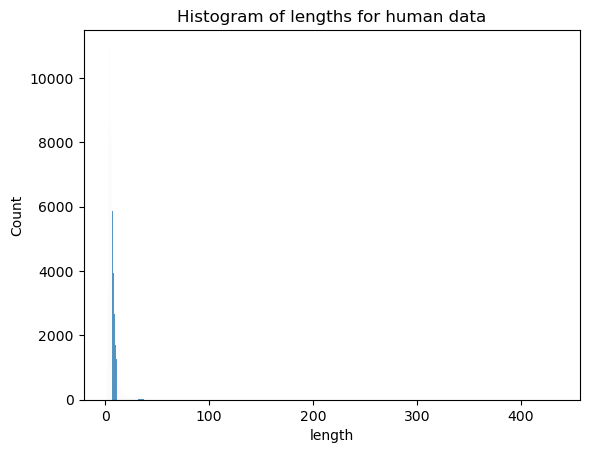

In [74]:
sns.histplot(data=finished_paths, x='length')
plt.title('Histogram of lengths for human data')

In [134]:
trimmed_finished = finished_paths[finished_paths['length'] <= 25]

fig = px.histogram(
    trimmed_finished, 
    x='length', 
    nbins=30,
    marginal='violin'
)

fig.update_layout(
    title='Histogram of lengths for human data'
)

fig.update_traces(marker=dict(line=dict(width=1))) 

fig.show()

fig.write_html('hist_human.html')

In [135]:
shortest_paths = dict(nx.all_pairs_shortest_path_length(wikispeedia))

# Now, just go through the paths and store the values in a list...
# We'll assume everything is in landmark_df
optimal_shortest_paths = []

for index, row in landmark_df.iterrows():
    optimal_shortest_paths.append(shortest_paths[row['source']][row['target']])

fig = px.histogram(
    optimal_shortest_paths, 
    # x='length', 
    nbins=30,
    marginal='violin'
)

fig.update_layout(
    title='Histogram of shortest paths (optimal values)'
)

fig.update_traces(marker=dict(line=dict(width=1))) 

fig.show()

fig.write_html('hist_shortest.html')

Text(0.5, 1.0, 'Histogram of lengths for optimal values')

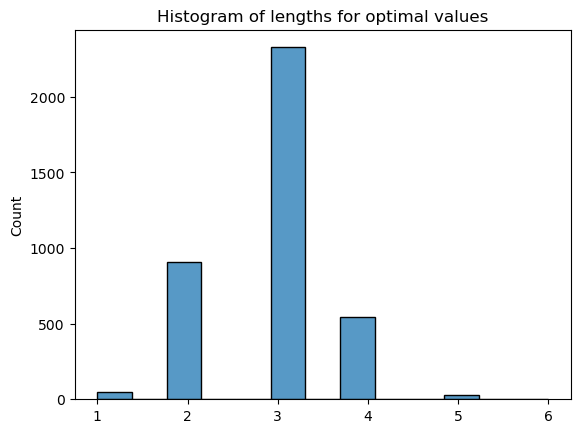

In [117]:
shortest_paths = dict(nx.all_pairs_shortest_path_length(wikispeedia))

# Now, just go through the paths and store the values in a list...
# We'll assume everything is in landmark_df
optimal_shortest_paths = []

for index, row in landmark_df.iterrows():
    optimal_shortest_paths.append(shortest_paths[row['source']][row['target']])

sns.histplot(data=optimal_shortest_paths)
plt.title('Histogram of lengths for optimal values')

## Trying to characterize paths

I wanna see if I can characterize the paths. This shit is painful, as we have to try and deal with the different elements. 

Most intuitive solution I could think of is getting the average embedding, do TSNE afterwards, and do a nice plot with color representing the lengths.

In [78]:
def get_mean_embeddings(elem_list: list) -> torch.tensor:
    result = get_embedding(elem_list[0])

    for i in range(1, len(elem_list)-1):
        result += get_embedding(elem_list[i])
    return result/len(elem_list)

In [79]:
def get_tsne_mean_embedding_of_path(input: pd.DataFrame) -> pd.DataFrame:
    mean_embedding = input['visited'].apply(get_mean_embeddings)
    
    temp = torch.zeros((input.shape[0], 384))
    for i in range(len(mean_embedding)-1):
        temp[i] = mean_embedding[i]

    tsne = TSNE()

    tsne_input = tsne.fit_transform(temp)
    
    # Need to expand the dimension of input length so the concatenation works out
    temp_test = np.concatenate([tsne_input, np.expand_dims(input['length'].values, 1)], axis=1)
    df = pd.DataFrame(temp_test, columns=['Feature 1', 'Feature 2', 'Length'])
    
    return df

In [80]:
semantic_rank_tsne_df = get_tsne_mean_embedding_of_path(semantic_rank_df)
landmark_tsne_df = get_tsne_mean_embedding_of_path(landmark_df)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0.5, 1.0, 'Semantic Rank Mean Embedding TSNE and Length')

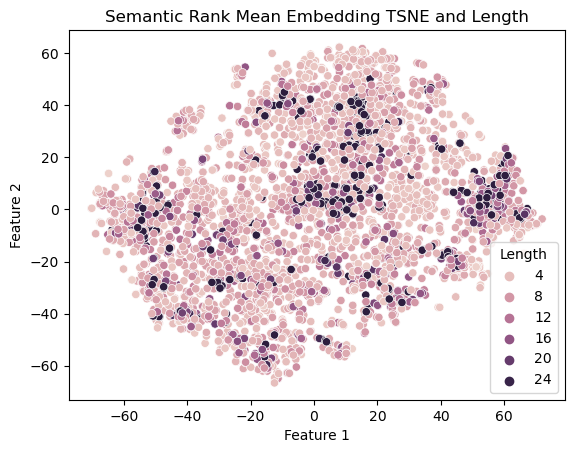

In [81]:
sns.scatterplot(data=semantic_rank_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Semantic Rank Mean Embedding TSNE and Length')

Text(0.5, 1.0, 'Landmark TSNE and Length')

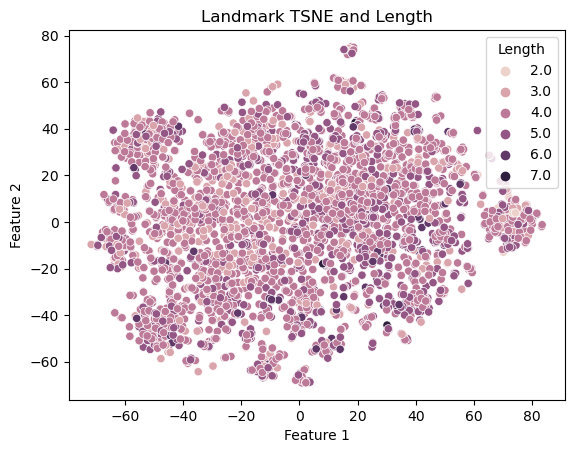

In [82]:
sns.scatterplot(data=landmark_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Landmark TSNE and Length')

In [83]:
# Now, just go through the paths and store the values in a list...
# I'll assume everything is in landmark_df
shortest_paths_themselves = []

for index, row in landmark_df.iterrows():
    shortest_paths_themselves.append(nx.shortest_path(wikispeedia, row['source'], row['target']))

temp = torch.zeros((landmark_df.shape[0], 384))
for i in range(landmark_df.shape[0]-1):
    temp[i] = get_mean_embeddings(shortest_paths_themselves[i])

tsne = TSNE()
tsne_input = tsne.fit_transform(temp)

lengths_optimal = [len(item) for item in shortest_paths_themselves]

lengths_optimal = np.expand_dims(np.array(lengths_optimal), 1)

# Need to expand the dimension of input length so the concatenation works out
temp_test = np.concatenate([tsne_input, lengths_optimal], axis=1)
df = pd.DataFrame(temp_test, columns=['Feature 1', 'Feature 2', 'Length'])

Text(0.5, 1.0, 'Optimal TSNE and Length')

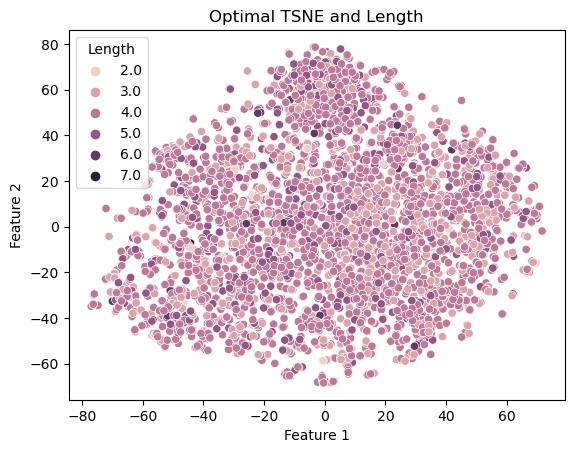

In [84]:
sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Optimal TSNE and Length')